In [1]:
from astropy.table import Table, vstack, Column
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import astropy.units as u
from IPython.display import display, Math
import seaborn as sns

In [2]:
#decals_splus = Table.read('GalfitM_sex_DECALS_SPLUS_17_xmatch.csv')
#decals_splus

In [3]:
model_raw = Table.read('GalfitM_DECALS_SPLUS_ahorasi.csv', format='ascii')
splus_raw = Table.read('GalfitM_output_SPLUS_minus.csv', format='ascii')
splus = splus_raw[splus_raw['type'] != 'PSF']
model = model_raw[model_raw['type'] != 'PSF'] 
#model_splus_raw = Table.read('splus_and_decals.csv', format='ascii')
#model_splus = model_splus_raw[model_splus_raw['type_1'] != 'PSF']
m = model.group_by('Group')

s = splus.group_by('Group')
keys = s.groups.keys
keys_model = m.groups.keys

#model = model[model['mag_r'] < 18.5]
#splus = splus[splus['MAG_r'] < 18.5]

#splus = splus[(splus['MAG_g'] < 18.5) & (splus['MAG_r'] < 18.5) & (splus['MAG_i'] < 18.5) & (splus['MAG_z'] < 18.5)]
#model = model[(model['mag_g'] < 18.5) & (model['mag_r'] < 18.5) & (model['mag_i'] < 18.5) & (model['mag_z'] < 18.5)]

# Encontrar las combinaciones únicas de 'Group' y 'Gal' en ambos catálogos
keys_splus = set(zip(splus['ra'], splus['dec']))
keys_model = set(zip(model['ra'], model['dec']))

# Filtrar 'model' para que solo conserve las combinaciones comunes de 'Group' y 'Gal'
common_keys = keys_splus.intersection(keys_model)
model_filtered = model[[tuple(row['ra', 'dec']) in common_keys for row in model]]
splus_filtered = splus[[tuple(row['ra', 'dec']) in common_keys for row in splus]]
# Resultado final
print(f"Total de galaxias en 'model' y 'splus' tras el filtrado: {len(model_filtered)}, {len(splus_filtered)}")
#print(len(model_splus))

Total de galaxias en 'model' y 'splus' tras el filtrado: 66, 66


In [11]:
# Mostrar los nombres de las columnas antes del cambio
#print("Nombres de columnas antes del cambio:", splus.colnames)

# Definir las columnas que deseas cambiar
#columnas_a_cambiar = ['n_R', 'n_G', 'n_I', 'n_Z', 'RE_R', 'RE_G', 'RE_I', 'RE_Z', 'MAG_R', 'MAG_G', 'MAG_I', 'MAG_Z', 'e_n_R', 'e_n_G', 'e_n_I', 'e_n_Z', 'e_RE_R', 'e_RE_G', 'e_RE_I', 'e_RE_Z', 'e_MAG_R', 'e_MAG_G', 'e_MAG_I', 'e_MAG_Z']

# Crear un diccionario para mapear los nombres antiguos a los nuevos solo para las columnas específicas
#column_mapping = {col: re.sub(r'_(G|R|I|Z)', lambda x: f'_{x.group(1).lower()}', col) for col in columnas_a_cambiar}

# Renombrar las columnas en la tabla
#for old_name, new_name in column_mapping.items():
#    if old_name in splus.colnames:
#        splus.rename_column(old_name, new_name)
#print(splus.colnames)

In [86]:
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])

    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)
    return final_table

In [6]:
#splus = filtrado(splus)
#splus

brickid,brickname,objid,type,ra,dec,ebv,flux_g,flux_r,flux_i,flux_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group,Gal,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Separation,ID,CHI2NU,XC_R,e_XC_R,YC_R,e_YC_R,MAG_r,e_MAG_r,RE_r,e_RE_r,n_r,e_n_r,AR_R,e_AR_R,PA_R,e_PA_R,XC_J0378,e_XC_J0378,YC_J0378,e_YC_J0378,MAG_J0378,e_MAG_J0378,RE_J0378,e_RE_J0378,n_J0378,e_n_J0378,AR_J0378,e_AR_J0378,PA_J0378,e_PA_J0378,XC_J0395,e_XC_J0395,YC_J0395,e_YC_J0395,MAG_J0395,e_MAG_J0395,RE_J0395,e_RE_J0395,n_J0395,e_n_J0395,AR_J0395,e_AR_J0395,PA_J0395,e_PA_J0395,XC_J0410,e_XC_J0410,YC_J0410,e_YC_J0410,MAG_J0410,e_MAG_J0410,RE_J0410,e_RE_J0410,n_J0410,e_n_J0410,AR_J0410,e_AR_J0410,PA_J0410,e_PA_J0410,XC_J0430,e_XC_J0430,YC_J0430,e_YC_J0430,MAG_J0430,e_MAG_J0430,RE_J0430,e_RE_J0430,n_J0430,e_n_J0430,AR_J0430,e_AR_J0430,PA_J0430,e_PA_J0430,XC_J0515,e_XC_J0515,YC_J0515,e_YC_J0515,MAG_J0515,e_MAG_J0515,RE_J0515,e_RE_J0515,n_J0515,e_n_J0515,AR_J0515,e_AR_J0515,PA_J0515,e_PA_J0515,XC_J0660,e_XC_J0660,YC_J0660,e_YC_J0660,MAG_J0660,e_MAG_J0660,RE_J0660,e_RE_J0660,n_J0660,e_n_J0660,AR_J0660,e_AR_J0660,PA_J0660,e_PA_J0660,XC_J0861,e_XC_J0861,YC_J0861,e_YC_J0861,MAG_J0861,e_MAG_J0861,RE_J0861,e_RE_J0861,n_J0861,e_n_J0861,AR_J0861,e_AR_J0861,PA_J0861,e_PA_J0861,XC_G,e_XC_G,YC_G,e_YC_G,MAG_g,e_MAG_g,RE_g,e_RE_g,n_g,e_n_g,AR_G,e_AR_G,PA_G,e_PA_G,XC_I,e_XC_I,YC_I,e_YC_I,MAG_i,e_MAG_i,RE_i,e_RE_i,n_i,e_n_i,AR_I,e_AR_I,PA_I,e_PA_I,XC_Z,e_XC_Z,YC_Z,e_YC_Z,MAG_z,e_MAG_z,RE_z,e_RE_z,n_z,e_n_z,AR_Z,e_AR_Z,PA_Z,e_PA_Z,XC_U,e_XC_U,YC_U,e_YC_U,MAG_u,e_MAG_u,RE_u,e_RE_u,n_u,e_n_u,AR_U,e_AR_U,PA_U,e_PA_U,u_auto,e_u_auto,J0378_auto,e_J0378_auto,J0395_auto,e_J0395_auto,J0410_auto,e_J0410_auto,J0430_auto,e_J0430_auto,g_auto,e_g_auto,J0515_auto,e_J0515_auto,r_auto,e_r_auto,J0660_auto,e_J0660_auto,i_auto,e_i_auto,J0861_auto,e_J0861_auto,z_auto,e_z_auto
int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,float64,str28,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,str10,str10,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,str9,str10,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,str9,str10,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,str9,str10,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
324660,0131m010,1904,SER,13.05099114252429,-1.111288683922806,0.05183192,103.06562,185.43976,246.9346,294.73126,16.46787,16.92776,14.921985,13.97155,0.637722,0.31094742,0.5030575,0.19211006,13.051125,-1.11125,20,4,00 52 12.27,-01 06 40.5,0.0413,--,19.6992,19.3486,0.5015192836991541,iDR4_3_STRIPE82-0019_0007419,1.14712122098981,209.4794,0.0219,289.5967,0.009,16.9572,0.009,7.1355,0.0517,1.0702,0.0144,0.2619,0.0014,78.0587,0.1662,209.4794,0.0219,289.5967,0.009,18.7849,0.0750,7.6233,0.1203,0.8592,0.0349,0.2619,0.0014,78.0587,0.1662,209.4794,0.0219,289.5967,0.009,18.5060,0.0904

In [4]:
filtros = ['g', 'r', 'i', 'z']
filtros_splus_filtered = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
for filtro in filtros:        
    model_filtered['n_' + filtro] = pd.to_numeric(model_filtered['n_' + filtro], errors='coerce')
    model_filtered['RE_' +filtro] = pd.to_numeric(model_filtered['RE_' + filtro], errors = 'coerce')*0.262
    model_filtered['e_n_' + filtro] = pd.to_numeric(model_filtered['e_n_' + filtro], errors='coerce')
    model_filtered['e_RE_' + filtro] = pd.to_numeric(model_filtered['e_RE_' + filtro], errors='coerce')*0.262
    #model_splus[f'n_{filtro}_1'] = pd.to_numeric(model_splus[f'n_{filtro}_1'], errors='coerce')
    #model_splus[f'RE_{filtro}_1'] = pd.to_numeric(model_splus[f'RE_{filtro}_1'], errors = 'coerce')*0.262
    #model_splus[f'e_n_{filtro}_1'] = pd.to_numeric(model_splus[f'e_n_{filtro}_1'], errors='coerce')
    #model_splus[f'e_RE_{filtro}_1'] = pd.to_numeric(model_splus[f'e_RE_{filtro}_1'], errors='coerce')*0.262
    #model_splus[f'n_{filtro}_2'] = pd.to_numeric(model_splus[f'n_{filtro}_2'], errors='coerce')
    #model_splus[f'RE_{filtro}_2'] = pd.to_numeric(model_splus[f'RE_{filtro}_2'], errors = 'coerce')*0.55
    #model_splus[f'e_n_{filtro}_2'] = pd.to_numeric(model_splus[f'e_n_{filtro}_2'], errors='coerce')
    #model_splus[f'e_RE_{filtro}_2'] = pd.to_numeric(model_splus[f'e_RE_{filtro}_2'], errors='coerce')*0.55
#H_0 = 67.4  # km/s/Mpc
#splus_filtered['Distance (Mpc)'] = (splus_filtered['zmemb'] * 300000) / H_0
for fil in filtros_splus_filtered:
    splus_filtered['n_' + fil] = pd.to_numeric(splus_filtered['n_' + fil], errors='coerce')
    splus_filtered['RE_' +fil] = pd.to_numeric(splus_filtered['RE_' + fil], errors = 'coerce')*0.55
    splus_filtered['MAG_' +fil] = pd.to_numeric(splus_filtered['MAG_' + fil], errors = 'coerce')
    splus_filtered['e_n_' + fil] = pd.to_numeric(splus_filtered['e_n_' + fil], errors='coerce')
    splus_filtered['e_RE_' + fil] = pd.to_numeric(splus_filtered['e_RE_' + fil], errors='coerce')*0.55
    #splus_filtered[f'RE_{fil}(kpc)'] = (splus_filtered[f'RE_{fil}'] * 0.55 * splus_filtered['Distance (Mpc)']) / 206.265
    #splus_filtered[f'e_RE_{fil}(kpc)'] = (splus_filtered[f'e_RE_{fil}'] * 0.55 * splus_filtered['Distance (Mpc)']) / 206.265


In [20]:
model_splus['dif'] = model_splus['n_r_1'] - model_splus['n_r_2']
model_splus['dif_re'] = model_splus['RE_r_1'] - model_splus['RE_r_2']

model_splus[abs(model_splus['dif_re']) > 1]

Group_1,Gal_1,ID_1,ra_1,dec_1,type_1,CHI2NU_1,RE_g_1,e_RE_g_1,MAG_g_1,e_MAG_g_1,n_g_1,e_n_g_1,RE_r_1,e_RE_r_1,n_r_1,e_n_r_1,RE_i_1,e_RE_i_1,n_i_1,e_n_i_1,RE_z_1,e_RE_z_1,n_z_1,e_n_z_1,objid_1,ebv_1,mag_g_1a,mag_r_1a,mag_i_1a,mag_z_1a,objid_2,type_2a,_RAJ2000_2,_DEJ2000_2,Group_2,Gal_2,ID_2,CHI2NU_2,RE_r_2,e_RE_r_2,n_r_2,e_n_r_2,RE_g_2,e_RE_g_2,n_g_2,e_n_g_2,RE_i_2,e_RE_i_2,n_i_2,e_n_i_2,RE_z_2,e_RE_z_2,n_z_2,e_n_z_2,dif,dif_re
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,str3,float64,float64,int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
28,4,10387,20.29108124601455,-32.04061563232854,SER,0.617147559289692,4.584449800000001,0.0047946,17.048,0.0009,1.2767,0.0019,4.468148,0.002882,1.3601,0.0011,4.357217200000001,0.0039562,1.4396,0.0016,4.2370902,0.0068644000000000005,1.5256,0.0028,10387,0.026457714,17.076982,16.608213,16.383247,16.297495,10387,SER,20.2909167,-32.0405,28,4,iDR4_3_SPLUS-s25s14_0029551,1.16271519890744,2.65309,0.032175,0.5862,0.037,2.59303,0.04350500000000001,0.5092,0.055,2.7101800000000003,0.047740000000000005,0.6593,0.0546,2.755665,0.06858500000000001,0.7176,0.0806,0.7739,1.815058
28,3,9981,20.27815691689498,-32.0500743178396,SER,0.617147559289692,2.6418770000000005,0.0026986000000000002,18.3549,0.0009,0.543,0.0024,2.7165994,0.0020174000000000004,0.6275,0.0013,2.7878896,0.0031964000000000003,0.7082,0.0023,2.8650486,0.0051876000000000005,0.7955,0.0042,9981,0.02635827,19.032486,18.93906,19.009768,19.038073,9981,SER,20.2784167,-32.0501111,28,3,iDR4_3_SPLUS-s25s14_0023490,1.16271519890744,5.7289650000000005,0.041195,1.2132,0.0126,5.87906,0.05808000000000001,0.8818,0.0176,5.58635,0.0594,1.5281,0.0198,5.472775,0.085855,1.779,0.0291,-0.5857000000000001,-3.0123656000000003
28,2,9141,20.2526136443005,-32.05851136884929,SER,0.617147559289692,5.5126372,0.0034846,16.9935,0.0006,0.8906,0.0011,5.4022304,0.002096,1.1242,0.0006,5.2968801999999995,0.0029868000000000004,1.347,0.001,5.1828316,0.0051876000000000005,1.5883,0.0017,9141,0.026182787,17.07119,16.410414,16.08536,15.880268,9141,SER,20.2524167,-32.0586111,28,2,iDR4_3_SPLUS-s25s14_0023466,1.16271519890744,2.26633,0.03773,1.0607,0.0556,2.2424600000000003,0.041800000000000004,0.7516,0.0651,2.289045,0.06479,1.3543,0.1035,2.30714,0.09256500000000001,1.5884,0.1512,0.06350000000000011,3.1359003999999997
28,1,8846,20.24462727220963,-32.06282642816967,SER,0.617147559289692,2.0629094,0.0026462,18.6756,0.0011,0.6432,0.0036,2.1082878000000003,0.0021746,0.7986,0.0021,2.1515702,0.0037990000000000003,0.9469,0.0042,2.198442,0.0061308000000000005,1.1074,0.0074,8846,0.026235,18.65307,18.44986,18.382,18.335512,8846,SER,20.2445,-32.0626111,28,1,iDR4_3_SPLUS-s25s14_0023259,1.16271519890744,4.326905,0.041855,1.2857,0.0167,4.45038,0.060555000000000005,1.1567,0.0255,4.209645,0.059895000000000004,1.4083,0.0264,4.116145,0.08723,1.5059,0.0396,-0.4871000000000001,-2.2186171999999997
32,4,8288,23.45944951864787,-69.33398403722262,SER,0.624711404673561,5.2434846,0.018837800000000002,16.8629,0.0029,1.55,0.0075,5.160325800000001,0.009563,1.7384,0.0038,5.080992200000001,0.016270200000000002,1.9181,0.0068,4.9951086,0.0303396,2.1127,0.0126,8288,0.022333538,16.90027,16.39398,16.192078,16.028032,8288,SER,23.4589167,-69.3338889,32,4,iDR4_3_MC0050_0038361,1.21635684263513,3.36633,0.036520000000000004,0.6116,0.0149,3.5352900000000007,0.06732,0.7511,0.0351,3.2057850000000006,0.042515,0.479,0.0224,3.077855,0.06809,0.3734,0.0398,1.1267999999999998,1.7939958000000007
32,1,6556,23.38287520992754,-69.31228126334031,SER,0.624711404673561,4.3014636,0.0204622,17.5442,0.0044,0.9633,0.0068,4.3550949999999995,0.0118948,1.0551,0.0038,4.4062636,0.0222176,1.1427,0.0074,4.4616504,0.039431,1.2375,0.0134,6556,0.0227

In [57]:
print(splus['RE_g(kpc)'].tolist())

[3.6424686243482274, 5.35013410408566, 7.141900054962284, 3.1112575130764704, 3.1503737804231995, 6.952987977998687, 3.513153637383157, 9.159692772276394, 1.9696362196048542, 2.7161199714204765, 3.2955889261466176, 3.0350993841936935, 2.400255703011187, 13.391247199718089, 9.17881207495673, 3.266985280595725, 3.7837918774507266, 4.658371001666564, 2.4436817435667484, 0.7649798547157185, nan, 8.305946554305088, 26.0804452225433, 5.111657869176821, 7.47478039147733, 2.2700600679270804, 4.813504526350066, 15.105775293709419, 0.2496728959771364, 0.809650445708076, 26.258897383670185, 43.215768370339184, 7.498477920246212, 6.491907918215606, 4.794987297389972, 5.7819239949530505, 4.201180940280145, 3.877810986284893, 10.680477267690485, 3.5452086354874215, 3.705340016275051, 0.9709277799488873, 4.00200212037452]


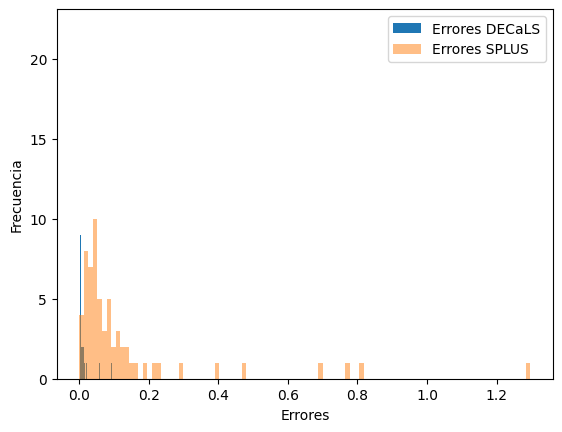

In [5]:
# Filtrar los NaN de los errores
errores_g_decals = model_filtered['e_RE_g']
errores_g_splus = splus_filtered['e_RE_g']

errores_filtrados_decals = errores_g_decals[(~np.isnan(errores_g_decals)) & (errores_g_decals != 0.0)]
errores_filtrados_splus = errores_g_splus[(~np.isnan(errores_g_splus)) & (errores_g_splus != 0.0)]

# Crear el histograma
plt.hist(errores_filtrados_decals, alpha=1, bins=100, label='Errores DECaLS')
plt.hist(errores_filtrados_splus, alpha=0.5, bins=100, label='Errores SPLUS')

# Ajustar los límites del eje x
#plt.xlim(0, 1)

# Etiquetas y leyenda
plt.xlabel('Errores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [6]:
valores_sersic = np.array([model_filtered['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus_filtered['n_'+filtro] for filtro in filtros])

errores_sersic = np.array([model_filtered['e_n_' + filtro] for filtro in filtros])
errores_sersic_splus = np.array([splus_filtered['e_n_' + filtro] for filtro in filtros])

# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Convertir a valores numéricos, forzando coerción
    valores = pd.to_numeric(valores, errors='coerce')
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    print(len(valores_filtrados))
    if len(valores_filtrados) > 0:
        return np.nanmedian(valores_filtrados)
    else:
        print('NO HAY VALORES QUE CALCULAR')
        return np.nan
def calcular_errores(valores):
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    if len(valores_filtrados) > 0:
        error = np.nanmedian(valores_filtrados)
        return error

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_sersic = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_sersic_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic_splus[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic'
error_valores_sersic = np.array([calcular_errores(errores_sersic[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic_splus'
error_valores_sersic_splus = np.array([calcular_errores(errores_sersic_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(f'{medianas_valores_sersic} $\pm$ {error_valores_sersic}')

print("\nMedianas para valores_sersic_splus:")
print(f'{medianas_valores_sersic_splus} $\pm$ {error_valores_sersic_splus}')

64
61
64
61
63
63
61
61
Medianas para valores_sersic:
[0.94595 1.1557  1.35545 1.5078 ] $\pm$ [0.003  0.0018 0.0034 0.0056]

Medianas para valores_sersic_splus:
[1.0158 1.2106 1.3004 1.388 ] $\pm$ [0.0615 0.0334 0.0493 0.0771]


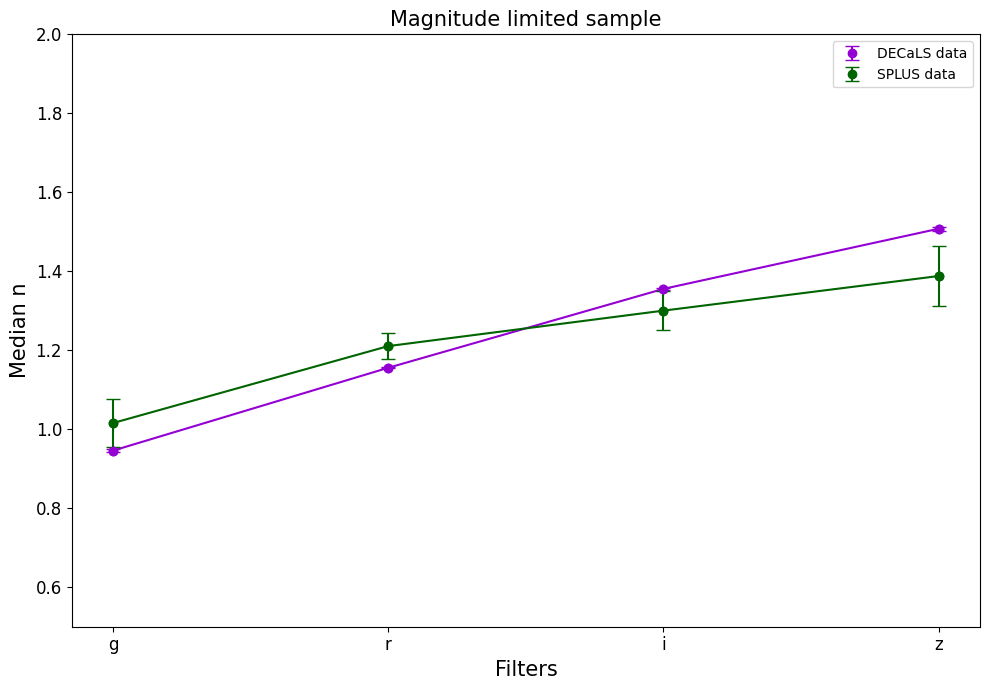

In [7]:
# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))

# Gráfico para valores_sersic con barras de error
plt.errorbar(filtros, medianas_valores_sersic, yerr=error_valores_sersic, fmt='o', capsize=5, color='darkviolet', label='DECaLS data')
plt.plot(filtros, medianas_valores_sersic, color='darkviolet', linestyle='-', marker='o')

# Gráfico para valores_sersic_splus con barras de error
plt.errorbar(filtros, medianas_valores_sersic_splus, yerr=error_valores_sersic_splus, fmt='o', capsize=5, color='darkgreen', label='SPLUS data')
plt.plot(filtros, medianas_valores_sersic_splus, color='darkgreen', linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)# Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('Median n', size=15)
plt.title('Magnitude limited sample', size=15)
plt.legend()
plt.ylim(0.5, 2)


plt.tight_layout()

# Mostrar el gráfico
plt.show()

La mediana de la diferencias en n: -0.04, con mínimo en -7.9663, y máximo 9.0195
La mediana de la diferencias en n: -0.1906, con mínimo en -8.4538, y máximo 6.8267
La mediana de la diferencias en n: -0.0816, con mínimo en -3.9111, y máximo 4.9812
La mediana de la diferencias en n: -0.1093, con mínimo en -5.047, y máximo 4.8418


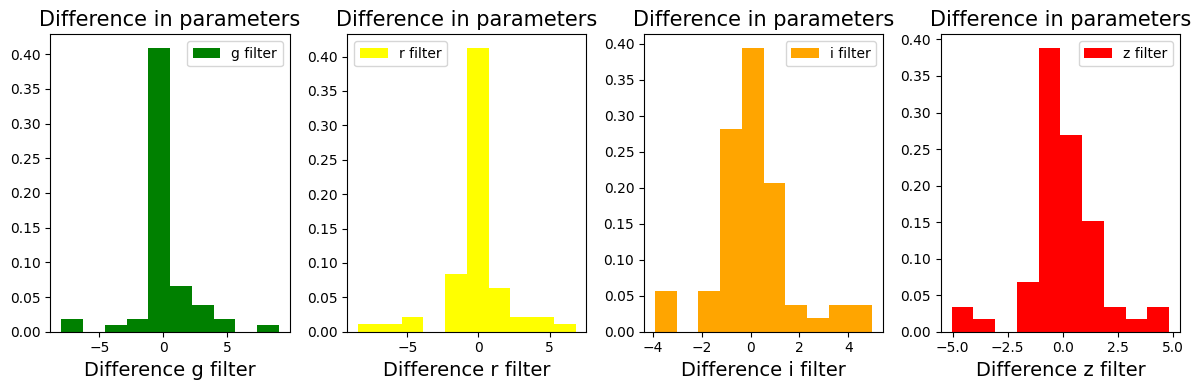

In [8]:
# Función para graficar Re vs n en grz.
def graficar_diferencias(axs, valores, valores_s, color_g, color_r, color_i, color_z, parameter):
    
    dif_g = valores[0] - valores_s[0]
    dif_r = valores[1] - valores_s[1]
    dif_i = valores[2] - valores_s[2]
    dif_z = valores[3] - valores_s[3]

    
    axs[0].hist(dif_g, density = True, bins=10, label='g filter', color=color_g)
    axs[0].set_xlabel('Difference g filter', fontsize = 14)
    axs[0].set_title(f'Difference in parameters', fontsize=15)

    axs[1].hist(dif_r, density = True, bins=10, label='r filter', color=color_r)
    axs[1].set_xlabel('Difference r filter', fontsize = 14)
    axs[1].set_title(f'Difference in parameters', fontsize=15)

    axs[2].hist(dif_i, density = True, bins=10, label='i filter', color=color_i)
    axs[2].set_xlabel('Difference i filter', fontsize = 14)
    axs[2].set_title(f'Difference in parameters', fontsize=15)
    
    axs[3].hist(dif_z, density = True, bins=10, label='z filter', color=color_z)
    axs[3].set_xlabel('Difference z filter', fontsize = 14)
    axs[3].set_title(f'Difference in parameters', fontsize=15)
    
    # Añadir leyenda en cada sub-gráfico
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    median_g = round(np.nanmedian(dif_g), 4)
    min_g = round(min(dif_g), 4)
    max_g = round(max(dif_g), 4)

    median_r = round(np.nanmedian(dif_r), 4)
    min_r = round(min(dif_r), 4)
    max_r = round(max(dif_r), 4)

    median_i = round(np.nanmedian(dif_i), 4)
    min_i = round(min(dif_i), 4)
    max_i = round(max(dif_i), 4)

    median_z = round(np.nanmedian(dif_z), 4)
    min_z = round(min(dif_z), 4)
    max_z = round(max(dif_z), 4)
    
    print(f'La mediana de la diferencias en {parameter}: {median_g}, con mínimo en {min_g}, y máximo {max_g}')
    print(f'La mediana de la diferencias en {parameter}: {median_r}, con mínimo en {min_r}, y máximo {max_r}')
    print(f'La mediana de la diferencias en {parameter}: {median_i}, con mínimo en {min_i}, y máximo {max_i}')
    print(f'La mediana de la diferencias en {parameter}: {median_z}, con mínimo en {min_z}, y máximo {max_z}')

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Graficar
graficar_diferencias(axs[:], valores_sersic, valores_sersic_splus, 'green', 'yellow', 'orange', 'red', 'n')
#graficar_re_n(axs[:], splus, 'cyan', 'darkorchid', 'pink', 'SPLUS data', 0.55)
#graficar_re_n(axs[:], d_stars[d_stars['n_i'] !=0.0], 'blue', 'black', 'lightgreen', 'Stars', 0.262)
# Ajustar diseño y mostrar gráficos
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
valores_re = np.array([model_filtered['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus_filtered[f'RE_' + filtro] for filtro in filtros])

errores_re = np.array([model_filtered['e_RE_' + filtro] for filtro in filtros])
errores_re_splus = np.array([splus_filtered[f'e_RE_' + filtro] for filtro in filtros])

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_re = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
#medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros([valores_re_splus[i][j][0] for j in range(len(splus_filtered))]) for i in range(len(filtros))])
medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re_splus[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic'
error_valores_re = np.array([calcular_errores(errores_re[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic_splus'
error_valores_re_splus = np.array([calcular_errores(errores_re_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_re:")
print(f'{medianas_valores_re} $\pm$ {error_valores_re}')

print("\nMedianas para valores_re_splus:")
print(f'{medianas_valores_re_splus} $\pm$ {error_valores_re_splus}')

58
57
59
56
56
57
57
56
Medianas para valores_re:
[3.0434837 2.929422  2.8819214 2.8608173] $\pm$ [0.0032619 0.0021746 0.0031964 0.0051876]

Medianas para valores_re_splus:
[3.1658275 3.079395  3.075655  2.9663975] $\pm$ [0.0593175 0.041195  0.0594    0.0865425]


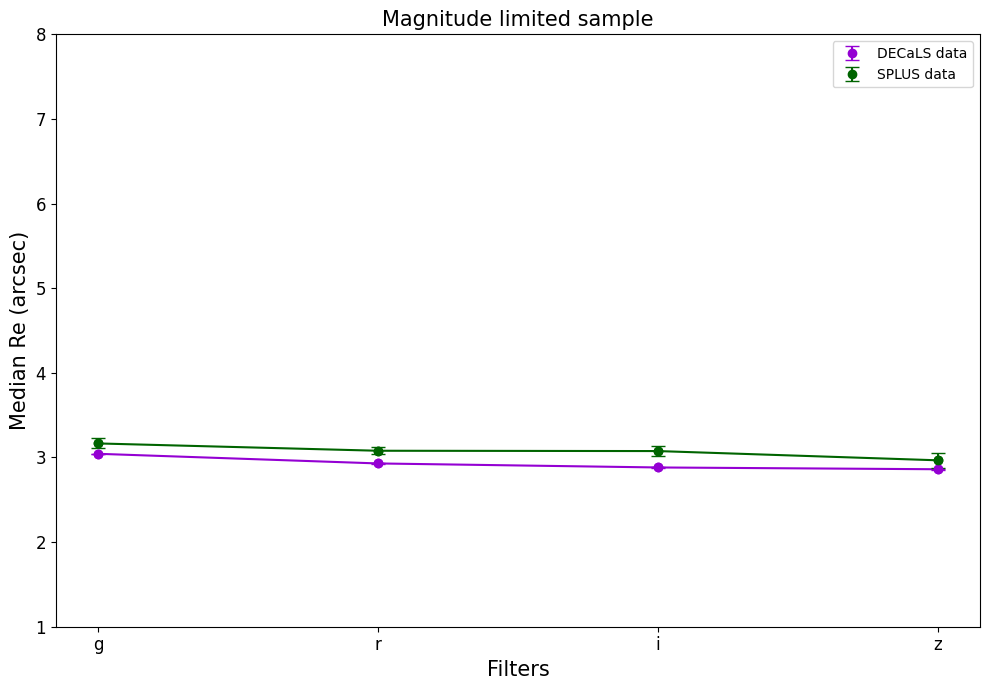

In [90]:
# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))

# Gráfico para valores_sersic con barras de error
plt.errorbar(filtros, medianas_valores_re, yerr=error_valores_re, fmt='o', capsize=5, color='darkviolet', label='DECaLS data')
plt.plot(filtros, medianas_valores_re, color='darkviolet', linestyle='-', marker='o')


# Gráfico para valores_sersic_splus con barras de error
plt.errorbar(filtros, medianas_valores_re_splus, yerr=error_valores_re_splus, fmt='o', capsize=5, color='darkgreen',label='SPLUS data')
plt.plot(filtros, medianas_valores_re_splus, color='darkgreen', linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)  # Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('Median Re (arcsec)', size=15)
plt.title('Magnitude limited sample', size=15)
plt.legend()
plt.ylim(1, 8)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

La mediana de la diferencias en Re: -0.1118, con mínimo en -8.044, y máximo 5.8528
La mediana de la diferencias en Re: -0.1669, con mínimo en -6.6872, y máximo 5.5493
La mediana de la diferencias en Re: -0.16, con mínimo en -6.5848, y máximo 6.0015
La mediana de la diferencias en Re: -0.2116, con mínimo en -8.241, y máximo 6.4558


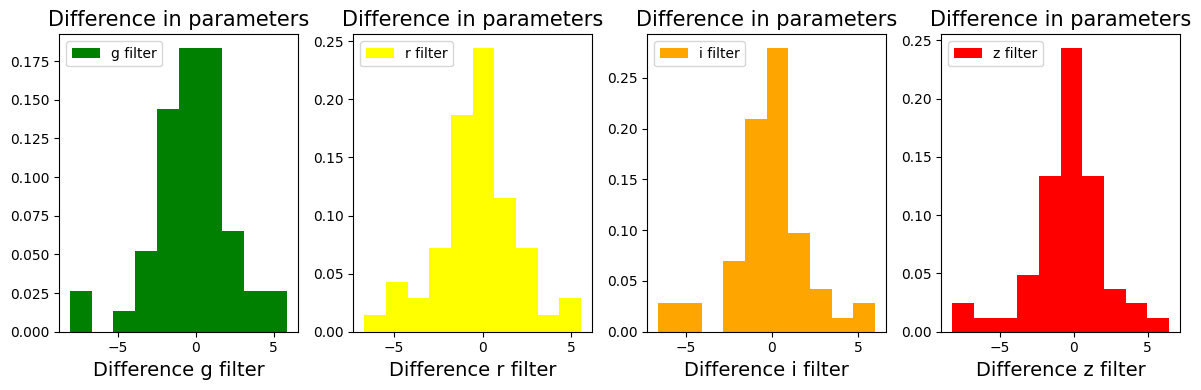

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
graficar_diferencias(axs[:], valores_re, valores_re_splus, 'green', 'yellow', 'orange', 'red', 'Re')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Obtener los grupos únicos en la tabla model
model_groups = set(model['Group'])

# Filtrar la tabla splus para que contenga solo los grupos presentes en model
filtered_splus = splus[np.isin(splus['Group'], list(model_groups))]


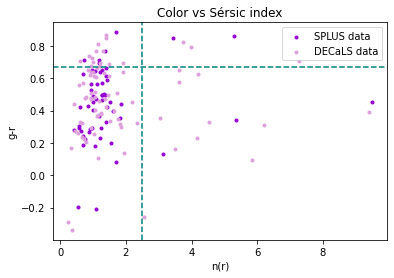

In [19]:
u_r_o = filtered_splus['MAG_g'] - filtered_splus['MAG_r']
g_r_model = model['mag_g'] - model['mag_r']
plt.scatter(filtered_splus['n_r'], u_r_o, marker='.', color= 'darkviolet', label='SPLUS data')
plt.scatter(model['n_r'], g_r_model, marker='.', color='plum', label='DECaLS data')

#plt.ylim(-3, 5)
#plt.xlim(0, )
plt.title('Color vs Sérsic index')
plt.xlabel('n(r)')
plt.ylabel('g-r')
# Añadir una línea horizontal en y=50
plt.legend()
plt.axhline(y=0.67, color='teal', linestyle='--')

# Añadir una línea vertical en x=2.5
plt.axvline(x=2.5, color='teal', linestyle='--')
plt.show()

In [21]:
decals_data = Table.read('GalfitM_DECALS_SPLUS_25_2.csv')
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals_data['n_' + filtro] = pd.to_numeric(decals_data['n_' + filtro], errors='coerce')
    decals_data['RE_' +filtro] = pd.to_numeric(decals_data['RE_' + filtro], errors = 'coerce')

In [47]:
grouped_decals = model.group_by('Group')

valid_groups=[]

for group in grouped_decals.groups:
    if any (group['zmemb'] != 0):
        valid_groups.append(group['Group'][0])

filtered_table = model[np.isin(model['Group'], valid_groups)]
filtered_table

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str11,float64,int64,float64,float64,str6,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,0.0
20,4,1904,13.05099114252429,-1.111288683922806,SER,0.550881294713299,607.4764,0.0036,767.6451,0.0014,15.2334,0.013,17.4378,0.0008,0.953,0.0019,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,14.5706,0.0083,16.8177,0.0005,1.0009,0.0011,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.9382,0.0088,16.5724,0.0005,1.0466,0.0013,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.2537,0.0143,16.3689,0.0009,1.0961,0.0022,0.2954,0.0001,78.0638,0.0124,324660,0131m010,1904,SER,0.05183192,103.06562,185.43976,246.9346,294.73126,1.2603335,1.2122216,1.1767341,1.1621677,1.0325946,545989.94,3.784927,491015.25,-0.49770728,17308538.0,0.21910955,12051584.0,17.467215,16.829493,16.518545,16.326435,16.46787,16.92776,14.921985,13.97155,0.637722,0.31094742,0.5030575,0.19211006,13.051125,-1.11125,00 52 12.27,-01 06 40.5,0.0413,--,19.6992,19.3486,Simbad,0.0
26,4,7828,16.84741713183292,-32.8290673708472,SER,0.793479330916477,430.8808,0.0004,765.8698,0.0008,13.6116,0.0037,15.9679,0.0002,1.2265,0.0009,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,12.2773,0.0024,15.0434,0.0001,1.3947,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,11.0043,0.0021,14.7278,0.0001,1.5551,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,9.6262,0.0033,14.4175,0.0002,1.7287,0.001,0.3725,0.0001,16.5187,0.0053,151766,0167m327,7828,SER,0.028982436,414.1549,920.47723,1297.2289,1622.3225,1.373282,1.2616813,1.158947,1.0554078,1.5113742,4127151.8,3.0896199,5022205.0,0.37618887,133092096.0,0.22846216,113639320.0,15.957093,15.089968,

In [110]:
# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb'][group['zmemb'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group').groups:
    result_groups.append(replace_zeros(group))

final_table = vstack(result_groups)

final_table

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str11,float64,int64,float64,float64,str6,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,0.0
20,4,1904,13.05099114252429,-1.111288683922806,SER,0.550881294713299,607.4764,0.0036,767.6451,0.0014,15.2334,0.013,17.4378,0.0008,0.953,0.0019,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,14.5706,0.0083,16.8177,0.0005,1.0009,0.0011,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.9382,0.0088,16.5724,0.0005,1.0466,0.0013,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.2537,0.0143,16.3689,0.0009,1.0961,0.0022,0.2954,0.0001,78.0638,0.0124,324660,0131m010,1904,SER,0.05183192,103.06562,185.43976,246.9346,294.73126,1.2603335,1.2122216,1.1767341,1.1621677,1.0325946,545989.94,3.784927,491015.25,-0.49770728,17308538.0,0.21910955,12051584.0,17.467215,16.829493,16.518545,16.326435,16.46787,16.92776,14.921985,13.97155,0.637722,0.31094742,0.5030575,0.19211006,13.051125,-1.11125,00 52 12.27,-01 06 40.5,0.0413,--,19.6992,19.3486,Simbad,0.0
26,4,7828,16.84741713183292,-32.8290673708472,SER,0.793479330916477,430.8808,0.0004,765.8698,0.0008,13.6116,0.0037,15.9679,0.0002,1.2265,0.0009,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,12.2773,0.0024,15.0434,0.0001,1.3947,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,11.0043,0.0021,14.7278,0.0001,1.5551,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,9.6262,0.0033,14.4175,0.0002,1.7287,0.001,0.3725,0.0001,16.5187,0.0053,151766,0167m327,7828,SER,0.028982436,414.1549,920.47723,1297.2289,1622.3225,1.373282,1.2616813,1.158947,1.0554078,1.5113742,4127151.8,3.0896199,5022205.0,0.37618887,133092096.0,0.22846216,113639320.0,15.957093,15.089968,

$log SFR_{NUV} (M_{\odot}yr^{-1}) = log L_{NUV}, corr(L_{\odot}) -9.33$


$log SFR_{FUV} (M_{\odot}yr^{-1}) = log L_{FUV}, corr(L_{\odot}) -9.51$

$A_{NUV} = -0.0495x^{3} + 0.4718x^{2} + 0.8998x + 0.2269$

$A_{FUV} = -0.0333y^{3} + 0.3522y^{2} + 1.1960y + 0.4967$


In [84]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table['Distance (Mpc)'] = (final_table['zmemb']*c)/H_0
final_table

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation,Distance (Mpc)
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str11,float64,int64,float64,float64,str6,float64,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,SER,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,00 52 09.70,-01 07 08.9,0.041238,--,19.5171,18.6617,Simbad,0.0,183.55192878338278
20,4,1904,13.05099114252429,-1.111288683922806,SER,0.550881294713299,607.4764,0.0036,767.6451,0.0014,15.2334,0.013,17.4378,0.0008,0.953,0.0019,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,14.5706,0.0083,16.8177,0.0005,1.0009,0.0011,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.9382,0.0088,16.5724,0.0005,1.0466,0.0013,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.2537,0.0143,16.3689,0.0009,1.0961,0.0022,0.2954,0.0001,78.0638,0.0124,324660,0131m010,1904,SER,0.05183192,103.06562,185.43976,246.9346,294.73126,1.2603335,1.2122216,1.1767341,1.1621677,1.0325946,545989.94,3.784927,491015.25,-0.49770728,17308538.0,0.21910955,12051584.0,17.467215,16.829493,16.518545,16.326435,16.46787,16.92776,14.921985,13.97155,0.637722,0.31094742,0.5030575,0.19211006,13.051125,-1.11125,00 52 12.27,-01 06 40.5,0.0413,--,19.6992,19.3486,Simbad,0.0,183.8278931750742
26,4,7828,16.84741713183292,-32.8290673708472,SER,0.793479330916477,430.8808,0.0004,765.8698,0.0008,13.6116,0.0037,15.9679,0.0002,1.2265,0.0009,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,12.2773,0.0024,15.0434,0.0001,1.3947,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,11.0043,0.0021,14.7278,0.0001,1.5551,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,9.6262,0.0033,14.4175,0.0002,1.7287,0.001,0.3725,0.0001,16.5187,0.0053,151766,0167m327,7828,SER,0.028982436,414.1549,920.47723,1297.2289,1622.3225,1.373282,1.2616813,1.158947,1.0554078,1.5113742,4127151.8,3.0896199,5022205.0,0.3761

### Para calcular magnitud absoluta, utilizamos el módulo de distancia
$m - M = 5log(\frac{D}{1pc}) - 5$
### Para luego obtener la Luminosidad mediante
$L_{x} = 10^{-0.4(M_{x}-M_{\odot, x})}L_{\odot, x}$

### O también con flujo
$m_{x} = -2.5log(F) - 48.6$

## $F = 10^{-\frac{(m_{x} + 48.6)}{2.5}}$

$L = 4\pi D^2 F$


In [22]:
def calcular_ssfr(archivo):
    H_0 = 67.4 #km/s/Mpc
    c = 300000
    L_sun = 3.83*10**33
    eta_fuv = 1.98e+15
    eta_nuv = 1.32e+15
    eta_w3 = 2.5e+13
    eta_w4 = 1.25e+13

    archivo['Distance (Mpc)'] = (archivo['zmemb']*c)/H_0
    archivo['M_FUV'] = archivo['FUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_NUV'] = archivo['NUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #Contiene transformación de sistema de referencia de Vega a AB
    #archivo['M_w3'] = archivo['mag_w3'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #archivo['M_w4'] = archivo['mag_w4'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_z'] = archivo['MAG_z'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5

    
    archivo['F_FUV'] = 10**(-(archivo['FUV']+48.6)/2.5)*eta_fuv
    archivo['F_NUV'] = 10**(-(archivo['NUV']+48.6)/2.5)*eta_nuv
    #archivo['F_w3'] = 10**(-(archivo['mag_w3']+48.6)/2.5)*eta_w3
    #archivo['F_w4'] = 10**(-(archivo['mag_w4']+48.6)/2.5)*eta_w4
    archivo['L_FUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_FUV']
    archivo['L_NUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_NUV']
    #archivo['L_w3'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w3']
    #archivo['L_w4'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w4']

    SFR_NUV=[]
    SFR_FUV=[]
    L=[]
    anuv=[]
    afuv=[]
    for i in range(len(archivo)):
        #Razón entre L_IR y L_FUV, NUV para la correción por polvo
        #x_nuv = np.log10(archivo['F_w4'][i]/archivo['F_NUV'][i])
        #y_fuv = np.log10(archivo['F_w4'][i]/archivo['F_FUV'][i])
        #Calculando A_nuv y A_fuv 
        #a_nuv = -0.0495*x_nuv**3 + 0.4718*x_nuv**2 + 0.8998*x_nuv + 0.2269
        #a_fuv = -0.0333*y_fuv**3 + 0.3522*y_fuv**2 + 1.1960*y_fuv + 0.4967

        #Calculando el flujo corregido por polvo
        #F_FUV = 10**(-(archivo['FUV'][i] - a_fuv + 48.6)/2.5)*eta_fuv
        F_NUV = 10**(-(archivo['NUV'][i] - 0.78 + 48.6)/2.5)*eta_nuv
        #Calculando la Luminosidad corregida en L_sun 
        #L_FUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_FUV)/L_sun
        L_NUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_NUV)/L_sun
        #L.append(L_FUV_cor)
        #Calculando la SFR en FUV y NUV
        #sfr_FUV = np.log10(L_FUV_cor) - 9.51
        sfr_NUV = np.log10(L_NUV_cor) - 9.33

        #anuv.append(a_nuv)
        #afuv.append(a_fuv)
        SFR_NUV.append(sfr_NUV)
        #SFR_FUV.append(sfr_FUV)

    archivo['logSFR_NUV'] = SFR_NUV
    #archivo['logSFR_FUV'] = SFR_FUV
    #print(anuv)
    #print(afuv)
    #print(min(anuv), max(anuv))
    #print(min(afuv), max(afuv))
    archivo['log(M_*)_z'] = (1.15 + 0.7*(archivo['MAG_g'] - archivo['MAG_z']) - 0.4*archivo['M_z'])*u.M_sun
    archivo['log_sSFR'] = archivo['logSFR_NUV'] - archivo['log(M_*)_z']
    return archivo
    
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])

    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)

    # Función para verificar si un valor es numérico
    def is_number(value):
        try:
            float(value)
            return True
        except (ValueError, TypeError):
            return False

    # Convertir los valores enmascarados a string y eliminar espacios en blanco
    #final_table['mag_w4'] = [str(x).strip() for x in final_table['mag_w4']]

    # Crear una máscara booleana para los valores numéricos
    #mask = [is_number(x) for x in final_table['mag_w4']]

    # Aplicar la máscara para filtrar la tabla
    #final_table = final_table[mask]

    # Convertir la columna a tipo flotante
    #final_table['mag_w4'] = final_table['mag_w4'].astype(float)

    # Eliminar filas con valores NaN
    #final_table = final_table[~np.isnan(final_table['mag_w4'])]

    # Eliminar filas con valores infinitos
    #final_table = final_table[np.isfinite(final_table['mag_w4'])]
    #archivo = final_table
    archivo = final_table

    return archivo

In [26]:
len(filtrado(model))

53

In [29]:
model_ssfr = calcular_ssfr(filtrado(model))
model_ssfr = model_ssfr['Group', 'Gal', 'zmemb', 'ra', 'dec', 'logSFR_NUV', 'log_sSFR', 'log(M_*)_z', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z']
survey_column = Column(['DECALS'] * len(model_ssfr), name='Survey')

model_ssfr.add_column(survey_column)
len(model_ssfr)
model_ssfr.write('decals_for_plots', format='csv', overwrite=True)

In [30]:
splus_ssfr = calcular_ssfr((filtrado(splus)))
splus_ssfr = splus_ssfr['Group', 'Gal', 'zmemb', 'ra', 'dec', 'logSFR_NUV', 'log_sSFR', 'log(M_*)_z', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z']
survey_column = Column(['SPLUS'] * len(splus_ssfr), name='Survey')

splus_ssfr.add_column(survey_column)
len(splus_ssfr)
#splus_ssfr.write('splus_for_plots', format='csv', overwrite=True)

44

In [119]:
median_ssfr_splus = np.nanmedian(splus_ssfr['log_sSFR'])
print(median_ssfr_splus)

-9.39722283897281


In [44]:
median_sfr = np.nanmedian(model_ssfr['logSFR_NUV'])
median_ssfr = np.nanmedian(model_ssfr['log_sSFR'])
print(median_sfr, median_ssfr)
for colname in model_ssfr.colnames:
    data = model_ssfr[colname]
    # Verificar si la columna es de tipo numérico
    if np.issubdtype(data.dtype, np.number):
        # Reemplazar inf y -inf por NaN solo en columnas numéricas
        data = np.where(np.isinf(data), np.nan, data)
        # Actualizar la columna en la tabla
        model_ssfr[colname] = data
model_ssfr

0.4243813469577056 -9.733740019249764


Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation,Distance (Mpc),M_FUV,M_NUV,M_w3,M_w4,M_z,F_FUV,F_NUV,F_w3,F_w4,L_FUV,L_NUV,L_w3,L_w4,logSFR_NUV,logSFR_FUV,log(M_*)_z,log_sSFR
float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str11,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,float64,float64,float64,float64
20.0,1.0,1471.0,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,34.2949,0.0154,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,32.8672,0.0116,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,31.505,0.0134,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,30.0303,0.0195,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660.0,0131m010,1471.0,SER,13.04012577583562,-1.119177251059751,0.051570516,230.60197,448.92276,636.275,798.9123,1.2603335,1.2122216,1.1767341,1.1621677,1.057419,1638754.4,8.487607,247327.45,0.43531945,54462148.0,-0.45720544,54293176.0,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,0.72327137,0.3786831,0.62581825,0.24713516,13.0404167,-1.1191389,20.0,1.0,00 52 09.70,-01 07 08.9,0.041238,0.0,19.5171,18.6617,Simbad,1.0561898463173114,0.0,183.55192878338278,-16.80169476238523,-17.65709476238523,-23.225457762385233,-24.113462762385232,-21.07504276238523,1.1215669167128568e-12,1.6439701633615704e-12,5.255393125978792e-12,5.953566555469724e-12,4.522148322196049e+42,6.628473794300774e+42,2.1189700634875378e+43,2.4004729997570634e+43,0.25561839488701743,0.1766083731494934,10.524380104954092,-10.268761710067075
20.0,4.0,1904.0,13.05099114252429,-1.111288683922806,SER,0.550881294713299,607.4764,0.0036,767.6451,0.0014,15.2334,0.013,17.4378,0.0008,0.953,0.0019,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,14.5706,0.0083,16.8177,0.0005,1.0009,0.0011,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.9382,0.0088,16.5724,0.0005,1.0466,0.0013,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,13.2537,0.0143,16.3689,0.0009,1.0961,0.0022,0.2954,0.0001,78.0638,0.0124,324660.0,0131m010,1904.0,SER,13.05099114252429,-1.111288683922806,0.05183192,103.06562,185.43976,246.9346,294.73126,1.2603335,1.2122216,1.1767341,1.1621677,1.0325946,545989.94,3.784927,491015.25,-0.49770728,17308538.0,0.21910955,12051584.0,17.467215,16.829493,16.5

In [37]:
decals_plots=Table.read('decals_for_plots', format='ascii')
splus_plots = Table.read('splus_for_plots', format='ascii')

decals_splus = vstack([decals_plots, splus_plots])
# Aplicar la condición para la columna 'Survey'
decals_splus['RE_g'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_g']*0.55, decals_splus['RE_g']*0.262)

decals_splus['RE_r'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_r']*0.55, decals_splus['RE_r']*0.262)

decals_splus['RE_z'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_z']*0.55, decals_splus['RE_z']*0.262)

H_0 = 67.4 #km/s/Mpc

decals_splus['Distance (Mpc)'] = (decals_splus['zmemb']*300000)/H_0
decals_splus['RE_g(kpc)'] = (decals_splus['RE_g']*decals_splus['Distance (Mpc)'])/206.265
decals_splus['RE_r(kpc)'] = (decals_splus['RE_r']*decals_splus['Distance (Mpc)'])/206.265
decals_splus['RE_z(kpc)'] = (decals_splus['RE_z']*decals_splus['Distance (Mpc)'])/206.265

decals_splus = decals_splus[~np.isnan(decals_splus['RE_g(kpc)'])]
len(decals_splus[decals_splus['Survey'] == 'DECALS'])
#decals_splus[decals_splus['RE_g(kpc)']>15]

47

In [51]:
median_n = np.nanmedian(decals_splus['n_r'][decals_splus['Survey']=='SPLUS'])
median_re = np.nanmedian(decals_splus['RE_r(kpc)'][(decals_splus['Survey']=='DECALS') & (decals_splus['log(M_*)_z'] > 10)])
#median_sfr = np.median(decals_splus['logSFR_NUV'])
#median_ssfr = np.median(decals_splus['log_sSFR'])
print(median_re, median_n)

7.177572694388344 1.2132


/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


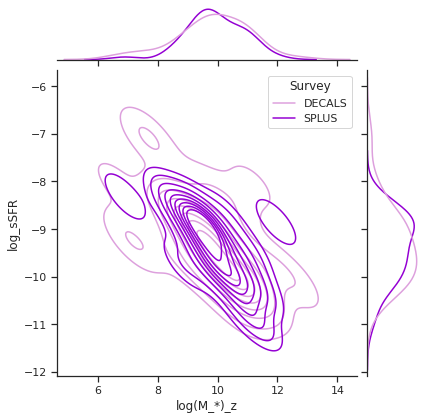

In [31]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['log_sSFR']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


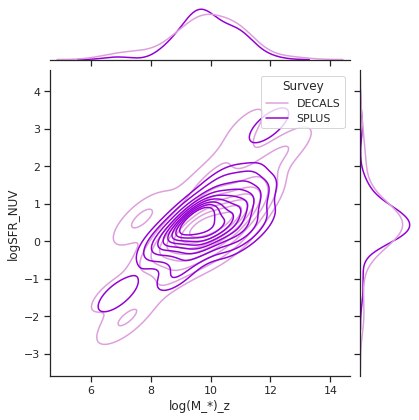

In [32]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['logSFR_NUV']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


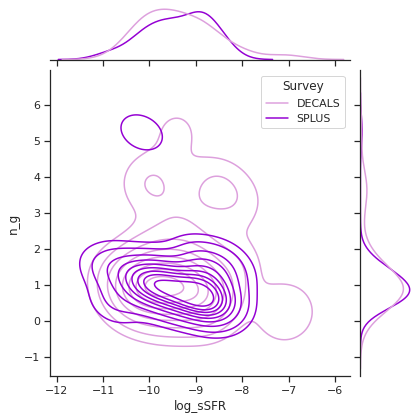

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


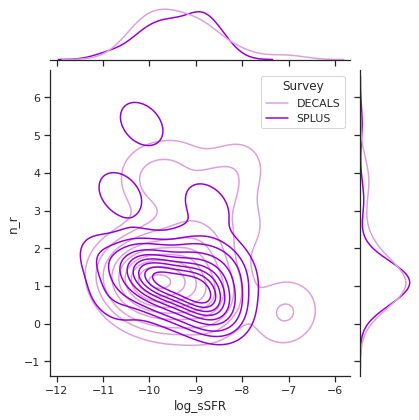

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


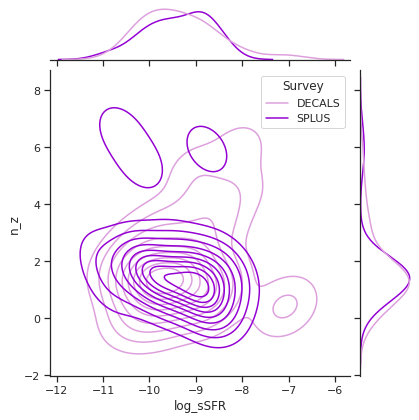

In [33]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

# Definir los datos
x = decals_splus['log_sSFR']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,# Llenar las curvas para mejor visualización
        palette=custom_palette
        #alpha=0.6
    ).set_axis_labels("log_sSFR", f"{col}")
    
    plt.show()  # Mostrar cada gráfico por separado


/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


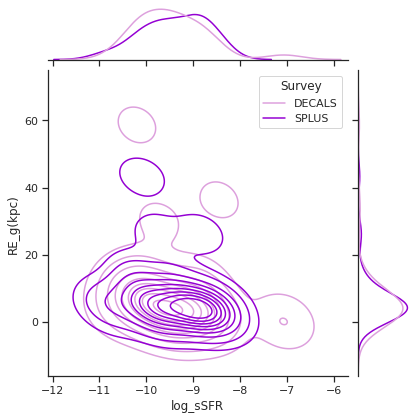

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


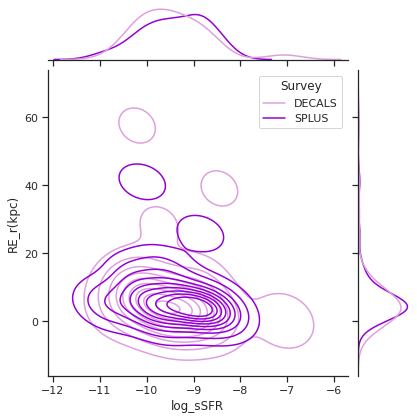

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


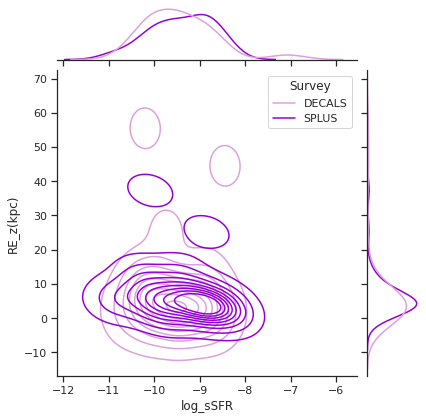

In [18]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}
# Definir los datos
x = decals_splus['log_sSFR']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # Llenar las curvas para mejor visualización
        palette=custom_palette
    ).set_axis_labels("log_sSFR", f"{col}")
    
    plt.show()  # Mostrar cada gráfico por separado

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


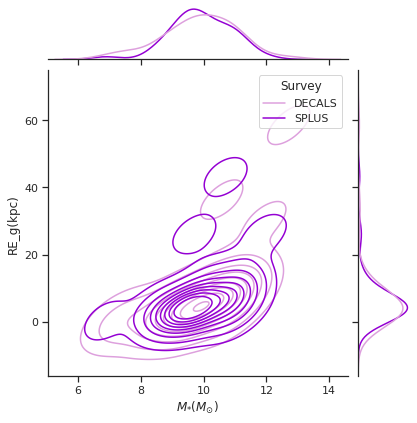

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


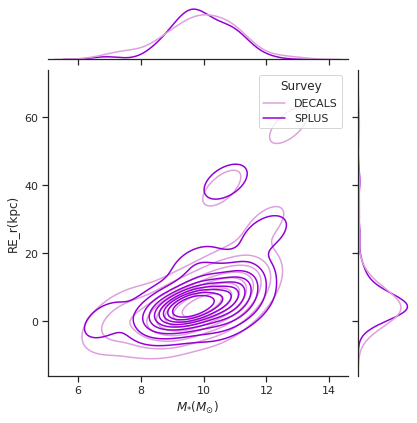

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


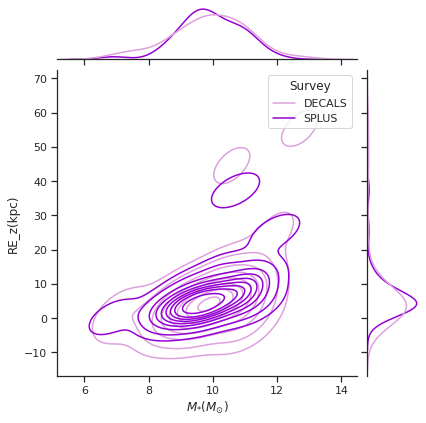

In [31]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}
# Definir los datos
x = decals_splus['log(M_*)_z']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # Llenar las curvas para mejor visualización
        palette=custom_palette
    ).set_axis_labels("$M_{*}(M_{\odot})$", f"{col}")
    #plt.xlim(8, 11.5)
    #plt.ylim(-1, 30)
    plt.show()

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


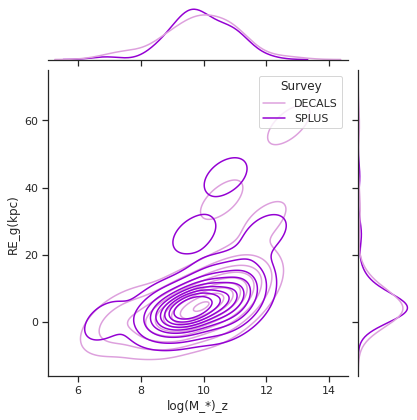

In [36]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['RE_g(kpc)']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)